In [1]:
# Text Classification / tc-nltk-lstm-rnn-topcat-3.ipynb
# Gourav Siddhad
# 24-Mar-2019

In [2]:
print('Importing Libraries', end='')

import pandas as pd
import numpy as np
from numpy.random import seed
import re
import os
import pandas as pd
import time

import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

from scipy import interp
from itertools import cycle

print(' - Done')

Importing Libraries

Using TensorFlow backend.


 - Done


In [3]:
documents = reuters.fileids()
print('Total Documents -', len(documents))

print('Extracting (Id, Docs and Labels)', end='')
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
all_docs = train_docs
all_docs += test_docs

train_labels = [reuters.categories(doc_id) for doc_id in train_docs_id]
test_labels  = [reuters.categories(doc_id) for doc_id in test_docs_id]
all_labels = train_labels
all_labels += test_labels
print(' - Done')

del train_docs
del test_docs
del train_labels
del test_labels

print('Documents - ', len(all_docs))
print('Labels  - ', len(all_labels))

# List of categories
categories = reuters.categories()
print('Categories - ', len(categories))

print('Caching Stop Words', end='')
cachedStopWords = stopwords.words("english")
print(' - Done')

Total Documents - 10788
Extracting (Id, Docs and Labels) - Done
Documents -  10788
Labels  -  10788
Categories -  90
Caching Stop Words - Done


In [4]:
catcount = dict()
topcount = 10

for cat in categories:
    catcount[cat] = 0

for lab in all_labels:
    for slab in lab:
        catcount[slab] += 1

df = pd.DataFrame.from_dict(catcount.items()) # , columns=['Category', 'Count']
df.columns = ['Category', 'Count']
df = df.sort_values(by=['Count'], ascending=False)
print(df.head())
print()
df1 = df.head(topcount)
print(df1.tail())

    Category  Count
21      earn   3964
0        acq   2369
46  money-fx    717
26     grain    582
17     crude    578

    Category  Count
84     trade    485
34  interest    478
71      ship    286
86     wheat    283
12      corn    237


In [5]:
cats = df1['Category']
cats = set(cats)

new_labels = []
new_docs = []

for i in range(len(all_labels)):
    templab = []
    for lab in all_labels[i]:
        if lab in cats:
            templab.append(lab)
    if len(templab) is not 0:
        new_labels.append(templab)
        new_docs.append(all_docs[i])
        
print('Original Data')
print(len(all_labels), len(all_docs))
print()
print('Modified data - Using Top', topcount,'Categories')
print(len(new_labels), len(new_docs))

Original Data
10788 10788

Modified data - Using Top 10 Categories
9034 9034


In [7]:
print('Sorting Train:Test Docs', end='')
X_train, X_test, y_train, y_test = train_test_split(new_docs, new_labels, test_size=0.2, random_state=42)
print(' - Done')

maxwords = 6000

print('Tokenizing', end='')
tk = Tokenizer(num_words=maxwords)
tk.fit_on_texts(X_train)
tk.fit_on_texts(X_test)
index_list_train = tk.texts_to_sequences(X_train)
index_list_test = tk.texts_to_sequences(X_test)
print(' - Done')

Sorting Train:Test Docs - Done
Tokenizing - Done


In [8]:
# max of index_list_train
# max of index_list_test

maxlen = 200

for i in index_list_train:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

for i in index_list_test:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

2153
2301


In [9]:
maxlen = 1600

print('Padding Sequences', end='')
x_train = sequence.pad_sequences(index_list_train, maxlen=maxlen)
x_test = sequence.pad_sequences(index_list_test, maxlen=maxlen)
print(' - Done')

print('Binarizing MultiLabels', end='')
lb = MultiLabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print(' - Done')

Padding Sequences - Done
Binarizing MultiLabels - Done


In [ ]:
del all_docs
del all_labels

In [10]:
def RNN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(maxwords, 512, input_length=maxlen)(inputs)
    layer = LSTM(256)(layer)
    layer = Dense(128, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate = 0.5)(layer) # rate = 1-keep_prob, keep_prob=0.5
    layer = Dense(len(cats), name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1600)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1600, 512)         3072000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 10)                1290      
__________

In [12]:
history = model.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.3, shuffle=True)

Train on 5058 samples, validate on 2169 samples
Epoch 1/25
5058/5058 [==============================] - 125s 25ms/step - loss: 2.1586 - acc: 0.4585 - val_loss: 1.6075 - val_acc: 0.4495
Epoch 2/25
5058/5058 [==============================] - 121s 24ms/step - loss: 1.3776 - acc: 0.5921 - val_loss: 1.1248 - val_acc: 0.6897
Epoch 3/25
5058/5058 [==============================] - 120s 24ms/step - loss: 1.0614 - acc: 0.7015 - val_loss: 1.0865 - val_acc: 0.7414
Epoch 4/25
5058/5058 [==============================] - 120s 24ms/step - loss: 0.9561 - acc: 0.7398 - val_loss: 0.9947 - val_acc: 0.7473
Epoch 5/25
5058/5058 [==============================] - 121s 24ms/step - loss: 0.8432 - acc: 0.7811 - val_loss: 0.8922 - val_acc: 0.7838
Epoch 6/25
5058/5058 [==============================] - 121s 24ms/step - loss: 0.6692 - acc: 0.8333 - val_loss: 0.7574 - val_acc: 0.8096
Epoch 7/25
5058/5058 [==============================] - 121s 24ms/step - loss: 0.5510 - acc: 0.8628 - val_loss: 0.6977 - val_acc: 

In [13]:
# Save Complete Model
model.save('tc-nltk-lstm-rnn-topcat-3.h5')

# Load a Saved Model
# model = load_model('tc-nltk-lstm-rnn.h5')

# Delete a model
# del model

# Save Model Configuration to JSON
model_json = model.to_json()
with open('tc-nltk-lstm-rnn-topcat-3.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('tc-nltk-lstm-rnn-topcat-3-weights.h5')

# Load Model Configuration from JSON
# json_file = open('tc-nltk-lstm-rnn.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights('tc-nltk-lstm-rnn-weights.h5')
# loaded_model.save('tc-nltk-lstm-rnn-weights.hdf5')
# loaded_model=load_model('tc-nltk-lstm-rnn-weights.hdf5')

In [14]:
accr = model.evaluate(x_test, y_test, batch_size=256)
print()
print('Loss: {:0.3f}\tAccuracy: {:0.3f}'.format(accr[0], accr[1]))

1807/1807 [==============================] - 11s 6ms/step

Loss: 0.799	Accuracy: 0.849


In [15]:
# plot_model(model, to_file='tc-nltk-lstm-4-model.png')

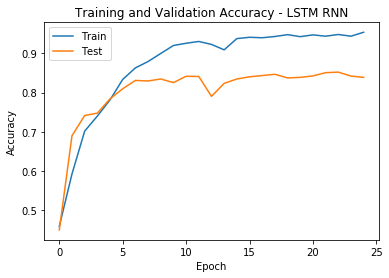

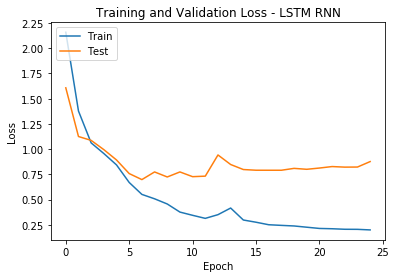

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy - LSTM RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-topcat-3-acc.png', dpi=300, pad_inches=0.1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss - LSTM RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-topcat-3-loss.png', dpi=300, pad_inches=0.1)
plt.show()